In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

import numpy
from tqdm import tqdm
from matplotlib import pyplot as plt
import cv2

torch.set_printoptions(precision=4, sci_mode=False)
numpy.set_printoptions(precision=4, suppress=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./mnist', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, drop_last=False)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
data_iter = iter(train_loader)
images, labels = next(data_iter)

In [4]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, bias=False)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, bias=False)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.conv1(x) # 6 @ 24 x 24
        x = self.pool1(x) # 6 @ 12 x 12
        x = self.conv2(x) # 16 @ 10 x 10
        x = self.pool2(x) # 16 @ 5 x 5
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [5]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.02

model = CNN().to(device)
# summary(model, (1, 28, 28))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [17]:
def new_learning_rate(loss):
    if loss <= 1:
        return 0.00001
    elif loss <= 2:
        return 0.0001
    elif loss <= 20:
        return 0.001
    elif loss <= 25:
        return 0.005
    elif loss <= 50:
        return 0.01
    else:
        return 0.02

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    model.train()
    
    for _, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        model = model.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f'Epoch {epoch} \tLoss: {total_loss}')
    
    new_lr = new_learning_rate(total_loss)
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
    

Epoch 0 	Loss: 32.4852727772668
Epoch 1 	Loss: 31.265612656250596
Epoch 2 	Loss: 30.047778451815248
Epoch 3 	Loss: 29.41753086121753
Epoch 4 	Loss: 28.25623828684911
Epoch 5 	Loss: 27.56511129718274
Epoch 6 	Loss: 26.73780795140192
Epoch 7 	Loss: 26.033422647044063
Epoch 8 	Loss: 25.520182609092444
Epoch 9 	Loss: 24.874386487761512


In [18]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.26%


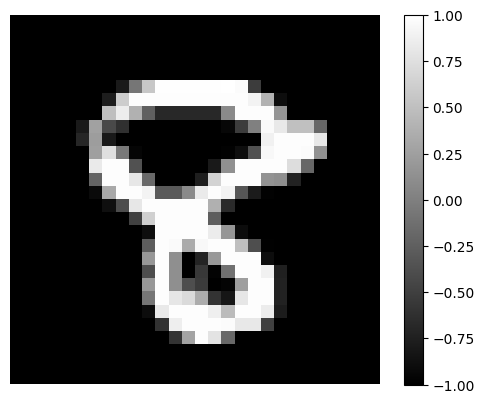

(tensor([ -7.4942, -16.1933,   5.1107,  10.9138, -15.1040,   7.9597,  -6.0072,
           0.6470,  22.4626,  -1.0391], device='cuda:0',
        grad_fn=<SelectBackward0>),
 tensor(8, device='cuda:0'))

In [19]:
plt.imshow(images[0][0], cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()

image = images.to(device)
ans = model(image)
ans[0], ans[0].argmax()

In [20]:
def deconv2d(input_tensor, kernel):
    """
    反卷积操作，每个输出通道使用不同的卷积核
    Args:
        input_tensor: 输入张量 [B, C_out, H, W]
        kernel: 卷积核 [C_out, C_in, kH, kW]
    Returns:
        output_tensor: 反卷积后的输出张量 [B, C_in, H + kH - 1, W + kW - 1]
    """
    B, C_out, H, W = input_tensor.shape
    C_in, kH, kW = kernel.shape[1:]  # 获取输入通道数和卷积核的高宽
    output_tensor = torch.zeros(B, C_in, H + kH - 1, W + kW - 1)
    
    # 遍历每个输出通道
    for c_out in range(C_out):
        for c_in in range(C_in):
            for i in range(H):
                for j in range(W):
                    output_tensor[:, c_in, i:i + kH, j:j + kW] += input_tensor[:, c_out, i:i + 1, j:j + 1] * kernel[c_out, c_in]

    return output_tensor

In [1]:
y0 = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])
# fc3
W_5, b_3 = model.fc3.weight.cpu().detach(), model.fc3.bias.cpu().detach()
y1, _, _, _ = torch.linalg.lstsq(W_5, y0 - b_3, rcond=None)
# fc2
W_4, b_2 = model.fc2.weight.cpu().detach(), model.fc2.bias.cpu().detach()
y2, _, _, _ = torch.linalg.lstsq(W_4, y1 - b_2, rcond=None)
# fc1
W_3, b_1 = model.fc1.weight.cpu().detach(), model.fc1.bias.cpu().detach()
y3, _, _, _ = torch.linalg.lstsq(W_3, y2 - b_1, rcond=None)

y3 = y3.reshape(torch.Size([16, 5, 5])).unsqueeze(0)
# pool2
y4 = nn.functional.interpolate(y3, scale_factor=2, mode='bilinear')
# conv2
conv_transpose2 = nn.ConvTranspose2d(16, 6, kernel_size=3, bias=False)
conv_transpose2.weight.data = model.conv2.weight.data.clone()
conv_transpose2.to(torch.device("cpu"))
y5 = conv_transpose2(y4)
# pool2
y6 = nn.functional.interpolate(y5, scale_factor=2, mode='bilinear')
# conv1
conv_transpose1 = nn.ConvTranspose2d(6, 1, kernel_size=5, bias=False)
conv_transpose1.weight.data = model.conv1.weight.data.clone()
conv_transpose1.to(torch.device("cpu"))
y7 = conv_transpose1(y6)

res = y7.squeeze().detach().reshape(28, 28).numpy()
plt.imshow(res, cmap='gray')
plt.title('res')
plt.colorbar()
plt.axis('off')
plt.show()

NameError: name 'torch' is not defined

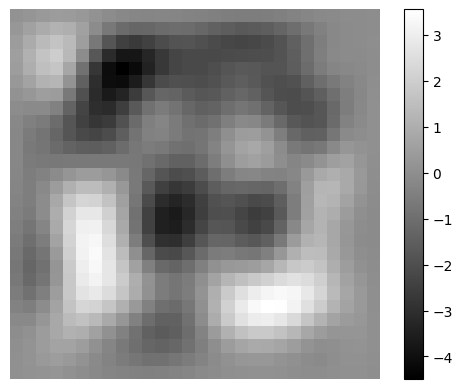

In [ ]:
y0 = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# fc3
W_5, b_3 = model.fc3.weight.cpu().detach(), model.fc3.bias.cpu().detach()
y1, _, _, _ = torch.linalg.lstsq(W_5, y0 - b_3, rcond=None)

# fc2
W_4, b_2 = model.fc2.weight.cpu().detach(), model.fc2.bias.cpu().detach()
y2, _, _, _ = torch.linalg.lstsq(W_4, y1 - b_2, rcond=None)

# fc1
W_3, b_1 = model.fc1.weight.cpu().detach(), model.fc1.bias.cpu().detach()
y3, _, _, _ = torch.linalg.lstsq(W_3, y2 - b_1, rcond=None)

y3 = y3.reshape(torch.Size([16, 5, 5])).unsqueeze(0)

# pool2
y4 = nn.functional.interpolate(y3, scale_factor=2, mode='bilinear')

# conv2
kernel2 = model.conv2.weight.cpu().detach()
y5 = deconv2d(y4, kernel2)
# conv_transpose2 = nn.ConvTranspose2d(16, 16, kernel_size=3, bias=False)
# conv_transpose2.weight.data = model.conv2.weight.data.clone()
# conv_transpose2.to(torch.device("cpu"))
# y5 = conv_transpose2(y4)

# pool2
y6 = nn.functional.interpolate(y5, scale_factor=2, mode='bilinear')

# conv1
kernel1 = model.conv1.weight.cpu().detach()  # 获取conv1的卷积核
y7 = deconv2d(y6, kernel1)
# conv_transpose1 = nn.ConvTranspose2d(16, 6, kernel_size=5, bias=False)
# conv_transpose1.weight.data = model.conv1.weight.data.clone()
# conv_transpose1.to(torch.device("cpu"))
# y7 = conv_transpose1(y6)

res = y7.squeeze().detach().numpy()
plt.imshow(res, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()

In [23]:
y7_tensor = torch.tensor(y7, dtype=torch.float32).to(device)
ans = model(y7_tensor)
ans[0], ans[0].argmax()

/tmp/ipykernel_632/2623411039.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y7_tensor = torch.tensor(y7, dtype=torch.float32).to(device)


(tensor([ -912.1132,   895.5464,  2094.9609,  1696.2827, -1198.4619,   623.1236,
         -1808.1384,  1131.7771,  -369.1905, -1492.2098], device='cuda:0',
        grad_fn=<SelectBackward0>),
 tensor(2, device='cuda:0'))